# Data Preprocessing Pipeline - GitHub Repositories

This notebook handles:
- **Feature selection** (most relevant features for recommendations)
- **Language balancing** (percentage-based filtering & equity)
- **Text preprocessing** (cleaning, normalization)
- **Topics standardization** (format consistency)
- **Data quality improvements** (missing values, outliers)


In [1]:
# Load data from database
import sys
sys.path.append('../src')

from infrastructure.postgres.database import SessionLocal
from domain.models.schema import Project

# Load all projects
db = SessionLocal()
try:
    projects = db.query(Project).all()
    print(f"Loaded {len(projects)} projects from database")
finally:
    db.close()

import pandas as pd

# Convert to DataFrame
df = pd.DataFrame([{
    'id': p.id,
    'title': p.title,
    'description': p.description,
    'readme': p.readme,
    'language': p.language,
    'topics': p.topics,
    'html_url': p.html_url,
    'stargazers_count': p.stargazers_count,
    'forks_count': p.forks_count,
    'open_issues_count': p.open_issues_count,
    'pushed_at': p.pushed_at
} for p in projects])

print(f"Original dataset shape: {df.shape}")
df.head()


Loaded 1938 projects from database
Original dataset shape: (1938, 11)


,id,title,description,readme,language,topics,html_url,stargazers_count,forks_count,open_issues_count,pushed_at
0,fdd16549-61ae-4df0-acb0-a462fbfe8ae9,xuchengsheng/spring-reading,涵盖了 Spring 框架的核心概念和关键功能，包括控制反转（IOC）容器的使用，面向切面编...,"<div align=""center"">\n <img alt=""logo"" src=...",Java,"java,spring,spring-boot,spring-cloud,spring-da...",https://github.com/xuchengsheng/spring-reading,9609,1213,36,2024-07-29 06:13:59+00:00
1,532345b5-6f26-438e-97a5-e8cdf3f77d9c,nicolargo/glances,Glances an Eye on your system. A top/htop alte...,===============================\nGlances - An ...,Python,"python,multi-platform,monitoring,system,termin...",https://github.com/nicolargo/glances,29274,1604,142,2025-07-12 16:17:31+00:00
2,9d06e651-1111-4a69-91e5-a1780da5ec63,Rakesh9100/CalcDiverse,CalcDiverse is a customized collection of calc...,"# <p align=""center"">✨CalcDiverse✨</p>\n<!-----...",JavaScript,"calculators,web-development,iwoc2024,jwoc2k24,...",https://github.com/Rakesh9100/CalcDiverse,151,394,1,2025-07-01 11:38:27+00:00
3,aba0006d-c6f1-4ee5-a317-65d3d0b4c255,ocornut/imgui,Dear ImGui: Bloat-free Graphical User interfac...,"Dear ImGui\n=====\n\n<center><b><i>""Give someo...",C++,"gui,gamedev,tools,ui,toolkit,native,imgui,api,...",https://github.com/ocornut/imgui,67046,11073,1172,2025-07-23 07:48:56+00:00
4,46f4a943-1ae9-43d1-9d99-19b46b13c2b0,twhite96/js-dev-reads,A list of books 📚and articles 📝 for the discer...,"<p align=""center"">\n <a href="" https://github...",None,"javascript,react,software-architecture,develop...",https://github.com/twhite96/js-dev-reads,3987,266,0,2022-08-18 15:35:10+00:00


## 1. Language Balancing & Filtering


Language Distribution:
language
Python        16.511868
JavaScript    16.408669
TypeScript    16.305470
Go            15.583075
Java          14.860681
Rust          14.809082
HTML           0.670795
C++            0.619195
Shell          0.464396
PHP            0.464396
Name: count, dtype: float64

Languages to keep (>=5.0%): 6
['Python', 'JavaScript', 'TypeScript', 'Go', 'Java', 'Rust']

After language filtering: 1831 repos (94.5% of original)


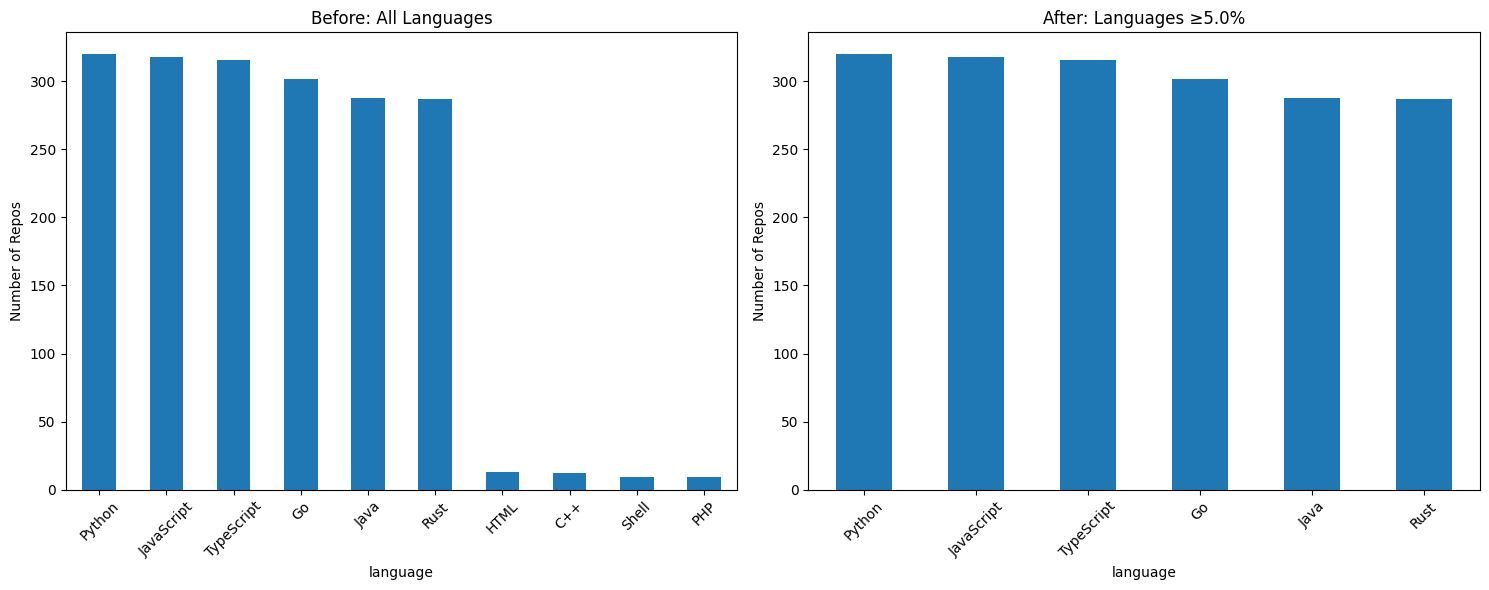

In [2]:
import matplotlib.pyplot as plt

# Language distribution analysis
language_counts = df['language'].value_counts()
language_percentages = (language_counts / len(df)) * 100

print("Language Distribution:")
print(language_percentages.head(10))

# Filter: Remove languages with <5% representation
MIN_LANGUAGE_PERCENT = 5.0
languages_to_keep = language_percentages[language_percentages >= MIN_LANGUAGE_PERCENT].index.tolist()

print(f"\nLanguages to keep (>={MIN_LANGUAGE_PERCENT}%): {len(languages_to_keep)}")
print(languages_to_keep)

# Apply filtering
df_filtered = df[df['language'].isin(languages_to_keep)].copy()
print(f"\nAfter language filtering: {len(df_filtered)} repos ({len(df_filtered)/len(df)*100:.1f}% of original)")

# Visualize before/after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before filtering
language_counts.head(10).plot(kind='bar', ax=ax1)
ax1.set_title('Before: All Languages')
ax1.set_ylabel('Number of Repos')
ax1.tick_params(axis='x', rotation=45)

# After filtering
df_filtered['language'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title(f'After: Languages ≥{MIN_LANGUAGE_PERCENT}%')
ax2.set_ylabel('Number of Repos')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [3]:
# Language distribution analysis (NO aggressive balancing for TF-IDF)
# For content-based recommendations, we keep natural distribution
print("=== LANGUAGE DISTRIBUTION STRATEGY ===")
print("Using natural distribution - TF-IDF handles imbalance automatically")
print()

# Use filtered dataset as-is (no artificial balancing)
df_balanced = df_filtered.copy()
print(f"Final dataset: {len(df_balanced)} repos")

# Show language distribution
print("\nFinal language distribution:")
language_dist = df_balanced['language'].value_counts()
print(language_dist)

# Show percentages
print("\nPercentages:")
percentages = (language_dist / len(df_balanced) * 100).round(1)
for lang, pct in percentages.items():
    print(f"  {lang}: {pct}%")


=== LANGUAGE DISTRIBUTION STRATEGY ===
Using natural distribution - TF-IDF handles imbalance automatically

Final dataset: 1831 repos

Final language distribution:
language
Python        320
JavaScript    318
TypeScript    316
Go            302
Java          288
Rust          287
Name: count, dtype: int64

Percentages:
  Python: 17.5%
  JavaScript: 17.4%
  TypeScript: 17.3%
  Go: 16.5%
  Java: 15.7%
  Rust: 15.7%


## 2. Feature Selection & Engineering


In [4]:
# Feature importance analysis
print("=== FEATURE SELECTION ===")
print()

# Text features (for TF-IDF)
text_features = ['title', 'description', 'readme']
print("TEXT FEATURES:")
for feature in text_features:
    non_empty = df_balanced[feature].notna().sum()
    coverage = (non_empty / len(df_balanced)) * 100
    avg_length = df_balanced[feature].dropna().str.len().mean()
    print(f"  {feature}: {coverage:.1f}% coverage, avg {avg_length:.0f} chars")

print()

# Categorical features
categorical_features = ['language', 'topics']
print("CATEGORICAL FEATURES:")
for feature in categorical_features:
    unique_count = df_balanced[feature].nunique()
    coverage = (df_balanced[feature].notna().sum() / len(df_balanced)) * 100
    print(f"  {feature}: {unique_count} unique values, {coverage:.1f}% coverage")

print()

# Numerical features
numerical_features = ['stargazers_count', 'forks_count', 'open_issues_count']
print("NUMERICAL FEATURES:")
for feature in numerical_features:
    mean_val = df_balanced[feature].mean()
    median_val = df_balanced[feature].median()
    print(f"  {feature}: mean={mean_val:.1f}, median={median_val:.1f}")

print()

# Feature selection decision
selected_features = {
    'text': ['title', 'description'],  # Skip readme if too sparse
    'categorical': ['language', 'topics'],
    'numerical': ['stargazers_count', 'open_issues_count']  # Skip forks_count if correlated
}

print("SELECTED FEATURES:")
for category, features in selected_features.items():
    print(f"  {category}: {features}")


=== FEATURE SELECTION ===

TEXT FEATURES:
  title: 100.0% coverage, avg 19 chars
  description: 99.6% coverage, avg 82 chars
  readme: 100.0% coverage, avg 16110 chars

CATEGORICAL FEATURES:
  language: 6 unique values, 100.0% coverage
  topics: 1584 unique values, 100.0% coverage

NUMERICAL FEATURES:
  stargazers_count: mean=28728.0, median=22088.0
  forks_count: mean=4203.1, median=2348.0
  open_issues_count: mean=473.0, median=184.0

SELECTED FEATURES:
  text: ['title', 'description']
  categorical: ['language', 'topics']
  numerical: ['stargazers_count', 'open_issues_count']


In [5]:
# Import required libraries for text processing
import re
import numpy as np
from collections import Counter

## 3. Text Preprocessing


In [6]:
# Title cleaning functions
def extract_repo_name(title):
    """Extract repository name from 'username/repo' format"""
    if pd.isna(title):
        return ""
    
    title = str(title)
    # Split by '/' and take the last part (repository name)
    if '/' in title:
        repo_name = title.split('/')[-1]
    else:
        repo_name = title
    
    return repo_name

# Text cleaning functions
def clean_text(text):
    """Clean and normalize text for TF-IDF processing"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove special characters but keep alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower().strip()
    
    return text

# Apply text cleaning
print("Cleaning text fields...")
df_clean = df_balanced.copy()

# Extract repository names from titles (remove username)
df_clean['title_repo'] = df_clean['title'].apply(extract_repo_name)
df_clean['title_clean'] = df_clean['title_repo'].apply(clean_text)

# Clean other text fields normally
for col in ['description', 'readme']:
    df_clean[f'{col}_clean'] = df_clean[col].apply(clean_text)
    
    # Show examples
    print(f"\n{col.upper()} CLEANING EXAMPLES:")
    for i in range(min(3, len(df_clean))):
        original = str(df_clean[col].iloc[i])[:100] + "..."
        cleaned = df_clean[f'{col}_clean'].iloc[i][:100] + "..."
        print(f"  Original: {original}")
        print(f"  Cleaned:  {cleaned}")
        print()

# Show title extraction examples
print("\nTITLE EXTRACTION EXAMPLES:")
for i in range(min(3, len(df_clean))):
    original = str(df_clean['title'].iloc[i])
    repo_name = df_clean['title_repo'].iloc[i]
    cleaned = df_clean['title_clean'].iloc[i]
    print(f"  Original: {original}")
    print(f"  Repo name: {repo_name}")
    print(f"  Cleaned: {cleaned}")
    print()

# Combine text features  
df_clean['combined_text'] = (
    df_clean['title_clean'].fillna('') + ' ' + 
    df_clean['description_clean'].fillna('') +
    df_clean['readme_clean'].fillna('')
) 

print(f"Combined text average length: {df_clean['combined_text'].str.len().mean():.0f} chars")


Cleaning text fields...

DESCRIPTION CLEANING EXAMPLES:
  Original: 涵盖了 Spring 框架的核心概念和关键功能，包括控制反转（IOC）容器的使用，面向切面编程（AOP）的原理与实践，事务管理的方式与实现，Spring MVC 的流程与控制器工作机制，以及 Spri...
  Cleaned:  spring ioc aop spring mvc spring boot spring spring...

  Original: Glances an Eye on your system. A top/htop alternative for GNU/Linux, BSD, Mac OS and Windows operati...
  Cleaned:  glances an eye on your system a top htop alternative for gnu linux bsd mac os and windows operating ...

  Original: CalcDiverse is a customized collection of calculators for various aspects of mathematics. Individual...
  Cleaned:  calcdiverse is a customized collection of calculators for various aspects of mathematics individuals...


README CLEANING EXAMPLES:
  Original: <div align="center">
    <img alt="logo" src="image/banner.png" style="height: 80px">
</div>
<div al...
  Cleaned:  div align center img alt logo src image banner png style height 80px div div align center h2 spring ...

  Original: ======================

## 4. Topics Standardization


In [7]:
# Topics preprocessing
def clean_topics(topics_str):
    """Clean and standardize topics"""
    if pd.isna(topics_str) or not str(topics_str).strip():
        return []
    
    # Split by comma and clean each topic
    topics = [topic.strip().lower() for topic in str(topics_str).split(',')]
    # Remove empty topics
    topics = [topic for topic in topics if topic]
    
    return topics

# Apply topics cleaning
df_clean['topics_clean'] = df_clean['topics'].apply(clean_topics)

# Analyze topic distribution
all_topics = []
for topic_list in df_clean['topics_clean']:
    all_topics.extend(topic_list)

topic_counter = Counter(all_topics)
print(f"Total unique topics: {len(topic_counter)}")
print(f"Average topics per repo: {np.mean([len(t) for t in df_clean['topics_clean']]):.1f}")

# Filter rare topics (optional)
MIN_TOPIC_FREQUENCY = 2
common_topics = {topic for topic, count in topic_counter.items() if count >= MIN_TOPIC_FREQUENCY}
print(f"Common topics (≥{MIN_TOPIC_FREQUENCY} occurrences): {len(common_topics)}")

# Filter topics
df_clean['topics_filtered'] = df_clean['topics_clean'].apply(
    lambda topics: [t for t in topics if t in common_topics]
)

print("\nTop 15 topics:")
for topic, count in topic_counter.most_common(15):
    print(f"  {topic}: {count}")

# Convert back to string format for compatibility
df_clean['topics_final'] = df_clean['topics_filtered'].apply(lambda x: ','.join(x))


Total unique topics: 5789
Average topics per repo: 8.1
Common topics (≥2 occurrences): 1747

Top 15 topics:
  javascript: 248
  rust: 201
  hacktoberfest: 195
  python: 170
  golang: 136
  go: 136
  react: 130
  typescript: 120
  java: 118
  cli: 106
  nodejs: 87
  ai: 81
  android: 79
  framework: 74
  docker: 68


## 5. Final Dataset Export


In [8]:
# Create final processed dataset
final_columns = [
    'id', 'title', 'language', 'topics_final',
    'stargazers_count', 'open_issues_count', 'html_url'
]

df_final = df_clean[final_columns].copy()
# Replace description with combined cleaned text
df_final['description'] = df_clean['combined_text']  
df_final = df_final.rename(columns={'topics_final': 'topics'})

print("=== FINAL PROCESSED DATASET ===")
print(f"Shape: {df_final.shape}")
print(f"Languages: {df_final['language'].nunique()}")
print(f"Avg text length: {df_final['description'].str.len().mean():.0f} chars")
print(f"Repos with topics: {(df_final['topics'].str.len() > 0).sum()}")

print("\nFinal language distribution:")
print(df_final['language'].value_counts())

print("\nSample of processed data:")
print(df_final.head(3))

# Export options controlled by environment variable
import os
SAVE_TO_DATABASE = os.getenv('SAVE_TO_DATABASE', 'true').lower() == 'true'

if SAVE_TO_DATABASE:
    # Save to training database using proper SQLAlchemy ORM
    from infrastructure.postgres.database import SessionLocal, engine
    from domain.models.schema import Base, ProjectTraining
    import uuid
    
    print("\n=== SAVING TO DATABASE ===")
    
    # Create tables using SQLAlchemy
    Base.metadata.create_all(bind=engine)
    print("✅ Created PROJECT_training table")
    
    # Clear existing training data using ORM
    db = SessionLocal()
    try:
        db.query(ProjectTraining).delete()
        db.commit()
        print("✅ Cleared existing training data")
        
        # Create ProjectTraining objects
        training_objects = []
        for _, row in df_final.iterrows():
            # Get original data from df_clean for non-processed fields
            orig_row = df_clean.loc[df_clean['id'] == row['id']].iloc[0]
            
            project_training = ProjectTraining(
                id=row['id'],
                title=row['title'],
                description=row['description'],  # Combined cleaned text
                readme=orig_row.get('readme', ''),
                language=row['language'],
                topics=row['topics'],  # Final processed topics
                html_url=row['html_url'],
                stargazers_count=row['stargazers_count'],
                forks_count=0,  # Default value
                open_issues_count=row['open_issues_count'],
                pushed_at=orig_row.get('pushed_at')
            )
            training_objects.append(project_training)
        
        # Bulk insert using SQLAlchemy ORM
        db.add_all(training_objects)
        db.commit()
        print(f"✅ Inserted {len(training_objects)} ProjectTraining objects")
        
    finally:
        db.close()
    
else:
    # Export to CSV (fallback option)
    os.makedirs('../data', exist_ok=True)
    df_final.to_csv('../data/processed_repositories.csv', index=False)
    print("\n✅ Exported to '../data/processed_repositories.csv'") -m

print("\n=== PREPROCESSING SUMMARY ===")
print(f"Original repos: {len(df)} → Final repos: {len(df_final)}")
print(f"Reduction: {(1 - len(df_final)/len(df))*100:.1f}%")
print("✅ Language balanced")
print("✅ Text cleaned and combined into description") 
print("✅ Topics standardized")
if SAVE_TO_DATABASE:
    print("✅ Saved to PROJECT_training database table")
else:
    print("✅ Saved to CSV file")
print("✅ Ready for ML training pipeline!")


=== FINAL PROCESSED DATASET ===
Shape: (1831, 8)
Languages: 6
Avg text length: 9725 chars
Repos with topics: 1571

Final language distribution:
language
Python        320
JavaScript    318
TypeScript    316
Go            302
Java          288
Rust          287
Name: count, dtype: int64

Sample of processed data:
                                     id                        title  \
0  fdd16549-61ae-4df0-acb0-a462fbfe8ae9  xuchengsheng/spring-reading   
1  532345b5-6f26-438e-97a5-e8cdf3f77d9c            nicolargo/glances   
2  9d06e651-1111-4a69-91e5-a1780da5ec63       Rakesh9100/CalcDiverse   

     language                                             topics  \
0        Java  java,spring,spring-boot,spring-cloud,spring-da...   
1      Python  python,monitoring,system,terminal,web,restful,...   
2  JavaScript    web-development,open-source,open-source-project   

   stargazers_count  open_issues_count  \
0              9609                 36   
1             29274                142  